In [26]:
##Essentiellement basé sur l'implémentation ici https://automaticaddison.com/extended-kalman-filter-ekf-with-python-code-example/
import math
import numpy as np
import matplotlib.pyplot as plt
import BaseDiff


In [63]:
#Paramètres 
dt = 0.1 #pas de temps
F = np.eye(3) #Matrice F dans le modèle Xt+1 = F*Xt + B*u
H = np.eye(3) #Matrice de mesure utilisée pour convertir les états estimés en états mesurés par les sensors au temps k 
R = np.eye(3) #Matrice bruit erreur de mesure à adapter en fonction de la confiance dans la mesure
Q = np.eye(3) #Matrice de bruit. Plus les entrées sont grandes, plus la variance des changements de mesures des sensors est gérée

In [80]:
#Modèle de déplacement utilisé pour prédire le prochain état 
#Paramètres position au temps t X = [x,y,theta] u = [v, omega]
#xt+1 = xt + v cos(theta)
#yt+1 = yt + v sin(theta) 
#theta_t+1 = theta_t + omega
#A adapter peut-être à notre problème
def motionModel(X,u) :
    B = np.array([[dt*math.cos(X[2]),0],[dt*math.sin(X[2]),0],[0,dt]])
    return (F@X) + (B@u)

In [74]:
#Prédiction du prochain état avant l' EKF
def prochainEtat(X,u) :
    bruit = np.array([0.01,0.01,0.003])

    return motionModel(X,u) + bruit

In [75]:
prochainEtat([9,0.5,0.5],[1.3,0.7])

array([9.12408573, 0.57232532, 0.573     ])

In [76]:
#Extended Kalman Filter

def ekf(posTriang,posprec,uk,covetatPrec) :
    #Estimation de l'état avant EKF : 
    posEstim = prochainEtat(posTriang,uk)
    #Calcul de la covariance de l'état 
    Pk = F @ covetatPrec @ F.T + Q
    #residu entre position donnée par la triangulation et la position estimée posEstim
    residu = posEstim - posTriang
    
    S = H @ Pk @ H.T + R
    
    #Initialisation de K
    K = Pk @ H.T @ np.linalg.pinv(S)
    
    # Update the state covariance estimate for time k
    Pk = Pk - (K @ H @ Pk)
    #Mise à jour de la position 

    posUpdate = posEstim + K@residu

    # Return the updated state and covariance estimates
    return posUpdate, Pk
    

In [68]:
ekf([9.353,0.284,0.007],[4.721,0.143,0.006],[4.5,0],np.eye(3))

(array([[ 9.0031084 , -0.81062327, -1.09287323],
        [10.14498923,  0.33125756,  0.0490076 ],
        [10.84279923,  1.02906756,  0.7468176 ]]),
 array([[0.66666667, 0.        , 0.        ],
        [0.        , 0.66666667, 0.        ],
        [0.        , 0.        , 0.66666667]]))

In [84]:
#Liste de 100 positions aléatoires
listePosObs = []
for i in range(100):
    listePosObs.append(np.random.uniform(0, 200, (3,1)))

In [94]:
#Test de ekf
#Position initiale 
posOptim = np.zeros(3)
#Matrice de covariance initiale
cov = np.eye(3)
distPosOptEstim = np.zeros(100)
compteur = 0
listePosOptim = []
for pos in listePosObs :
    posOptim, cov = ekf(pos,posOptim,[4.5,0],cov)
    distPosOptEstim[compteur] = np.linalg.norm(posOptim - pos)

    listePosOptim.append(posOptim)
    compteur = compteur + 1


In [95]:
iterations = np.arange(0,100)

array([1.25870512, 1.30416626, 1.25352258, 1.22422999, 1.29989271,
       1.29376308, 1.25545628, 1.29748771, 1.28540622, 1.23456889,
       1.3007871 , 1.28751555, 1.27425322, 1.22206957, 1.29890416,
       1.22579552, 1.29899414, 1.26674534, 1.26948804, 1.27245469,
       1.29434948, 1.27106243, 1.27758472, 1.30045167, 1.29139485,
       1.29894894, 1.23509941, 1.28794705, 1.23285888, 1.22897404,
       1.29991562, 1.22504114, 1.22183073, 1.23200217, 1.29847569,
       1.27571254, 1.25499666, 1.25004295, 1.22329985, 1.26277144,
       1.24418711, 1.23373305, 1.22970444, 1.22922681, 1.29462551,
       1.29171335, 1.25687992, 1.25720071, 1.29471548, 1.22406565,
       1.27271127, 1.25800521, 1.24957627, 1.29306732, 1.2971025 ,
       1.22213255, 1.25377038, 1.24120166, 1.28309748, 1.27614973,
       1.30071898, 1.22768072, 1.22258556, 1.22279962, 1.24920479,
       1.28501541, 1.23375558, 1.2217847 , 1.29327974, 1.23283642,
       1.23667255, 1.28113912, 1.22985346, 1.30022681, 1.30028

Text(0, 0.5, '||position triangulée-EKF||')

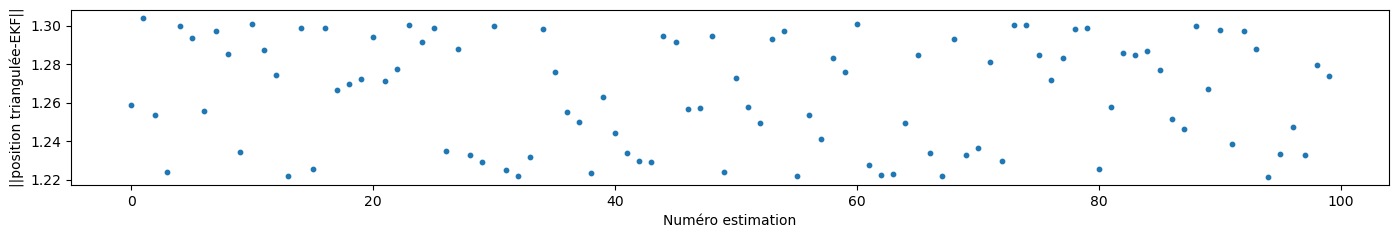

In [104]:
#Ecarts position triangulée et EKF
plt.figure(figsize=(17,5))
plt.subplot(2, 1, 1)
plt.scatter(iterations,distPosOptEstim , marker='o', s=10, label="True label")
plt.xlabel('Numéro estimation')
plt.ylabel("||position triangulée-EKF||")
